In [195]:
import pandas as pd
import numpy as np
import yfinance as yf
import altair as alt
from pytz import timezone
from altair_viewer import show
from matplotlib import pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
# set_embed_options(actions=False)
# enable_mime_rendering()

In [2]:
# ticker = yf.Ticker("TATAMOTORS.NS")  # Replace "AAPL" with the desired stock symbol
ticker = yf.Ticker("AAPL")  # Replace "AAPL" with the desired stock symbol

data= ticker.history(period="1d", start="2010-01-01", end="2023-05-31")
data= data.reset_index()
data


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-01-04 00:00:00-05:00,6.478688,6.511167,6.446815,6.496294,493729600,0.0,0.0
1,2010-01-05 00:00:00-05:00,6.514205,6.544256,6.473225,6.507526,601904800,0.0,0.0
2,2010-01-06 00:00:00-05:00,6.507524,6.533326,6.397335,6.404014,552160000,0.0,0.0
3,2010-01-07 00:00:00-05:00,6.427690,6.435279,6.345731,6.392174,477131200,0.0,0.0
4,2010-01-08 00:00:00-05:00,6.383676,6.435280,6.346036,6.434672,447610800,0.0,0.0
...,...,...,...,...,...,...,...,...
3369,2023-05-23 00:00:00-04:00,173.130005,173.380005,171.279999,171.559998,50747300,0.0,0.0
3370,2023-05-24 00:00:00-04:00,171.089996,172.419998,170.520004,171.839996,45143500,0.0,0.0
3371,2023-05-25 00:00:00-04:00,172.410004,173.899994,171.690002,172.990005,56058300,0.0,0.0
3372,2023-05-26 00:00:00-04:00,173.320007,175.770004,173.110001,175.429993,54794100,0.0,0.0


In [3]:
stock= data.copy()

In [4]:
stock["month"]=stock.Date.dt.month
stock["week"]= stock.Date.dt.week
stock["day"]= stock.Date.dt.day
stock["year"]= stock.Date.dt.year
stock["day_of_week"]=stock.Date.dt.dayofweek
# stock.set_index("Date", drop= False, inplace=True)
stock.head()

C:\Users\zeesh\AppData\Local\Temp/ipykernel_22924/4164509427.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  stock["week"]= stock.Date.dt.week


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,week,day,year,day_of_week
0,2010-01-04 00:00:00-05:00,6.478688,6.511167,6.446815,6.496294,493729600,0.0,0.0,1,1,4,2010,0
1,2010-01-05 00:00:00-05:00,6.514205,6.544256,6.473225,6.507526,601904800,0.0,0.0,1,1,5,2010,1
2,2010-01-06 00:00:00-05:00,6.507524,6.533326,6.397335,6.404014,552160000,0.0,0.0,1,1,6,2010,2
3,2010-01-07 00:00:00-05:00,6.427690,6.435279,6.345731,6.392174,477131200,0.0,0.0,1,1,7,2010,3
4,2010-01-08 00:00:00-05:00,6.383676,6.435280,6.346036,6.434672,447610800,0.0,0.0,1,1,8,2010,4


In [5]:
stock.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
month           0
week            0
day             0
year            0
day_of_week     0
dtype: int64

### Exploratory Data Analysis using 
- Altair library

In [6]:
closing_prices= stock[['Date', 'Close']]

chart= alt.Chart(closing_prices).mark_line().encode(
    x='Date:T',
    y='Close:Q',
    tooltip=['Date:T', 'Close:Q']
).properties(
    title='Closing Prices Over Time',
    width=800,
    height=400
)
chart

alt.Chart(...)

In [7]:
ohlc_data = stock[['Date', 'Open', 'High', 'Low', 'Close']]

chart = alt.Chart(ohlc_data).mark_rule().encode(
    x='Date:T',
    y='Low:Q',
    y2='High:Q',
    color=alt.condition(
        "datum.Close >= datum.Open",
        alt.value("#06982d"),
        alt.value("#ae1325")
    ),
    tooltip=['Date:T', 'Open:Q', 'High:Q', 'Low:Q', 'Close:Q']
).properties(
    title='Stock Candlestick Chart',
    width=800,
    height=400
)

chart


alt.Chart(...)

# Trends for 2019

In [10]:
stock[stock['year']==2019]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,week,day,year,day_of_week
2264,2019-01-02 00:00:00-05:00,37.265494,38.218245,37.106702,37.994492,148158800,0.0,0.0,1,1,2,2019,2
2265,2019-01-03 00:00:00-05:00,34.640629,35.059263,34.164255,34.209969,365248800,0.0,0.0,1,1,3,2019,3
2266,2019-01-04 00:00:00-05:00,34.772945,35.740131,34.597313,35.670357,234428400,0.0,0.0,1,1,4,2019,4
2267,2019-01-07 00:00:00-05:00,35.776219,35.807498,35.102557,35.590961,219111200,0.0,0.0,1,2,7,2019,0
2268,2019-01-08 00:00:00-05:00,35.983133,36.526876,35.732918,36.269440,164101200,0.0,0.0,1,2,8,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,2019-12-24 00:00:00-05:00,69.523637,69.572482,69.091391,69.421066,48478800,0.0,0.0,12,52,24,2019,1
2512,2019-12-26 00:00:00-05:00,69.555375,70.815490,69.526071,70.798393,93121200,0.0,0.0,12,52,26,2019,3
2513,2019-12-27 00:00:00-05:00,71.093887,71.789882,70.361262,70.771530,146266000,0.0,0.0,12,52,27,2019,4
2514,2019-12-30 00:00:00-05:00,70.688506,71.477301,69.653065,71.191574,144114400,0.0,0.0,12,1,30,2019,0


In [34]:

start_date= pd.to_datetime('2019-01-01')
end_date= pd.to_datetime('2019-12-30')

# timezone_str = 'Asia/Kolkata'
timezone_str = 'America/New_York'



start_date= start_date.tz_localize(timezone(timezone_str))
end_date= end_date.tz_localize(timezone(timezone_str))


temp= stock[(stock['Date']>=start_date) & (stock['Date']<=end_date)].reset_index(drop=True)


# bars= alt.Chart(temp).mark_trail(color='orange').encode(
bars= alt.Chart(temp).mark_rule(color='orange').encode(
    x='Date:T',
    y='Low:Q',
    y2='High:Q',
    color=alt.condition(
        "datum.Close >= datum.Open",
        alt.value("#06982d"),
        alt.value("#ae1325")
        ),
    tooltip=['Date:T','Low:Q','High:Q'],
).properties(
    width=700,
    height=300,
    title={
        "text":['Trend of Low and High in 2019'],
        "subtitle":['There is a continuous increase in Open'],
        "fontSize": 15,
        "fontWeight":'bold',
        "font": 'Courier New'
    }
)
text= bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
)


# Enable zooming
# selection = alt.selection_interval(bind='scales', encodings=['x'])
# bars = bars.add_selection(selection)

# Display the chart
(bars+text)

alt.LayerChart(...)

In [35]:

start_date= pd.to_datetime('2019-01-01')
end_date= pd.to_datetime('2019-12-30')

# timezone_str = 'Asia/Kolkata'
timezone_str = 'America/New_York'



start_date= start_date.tz_localize(timezone(timezone_str))
end_date= end_date.tz_localize(timezone(timezone_str))


temp= stock[(stock['Date']>=start_date) & (stock['Date']<=end_date)].reset_index(drop=True)


bars= alt.Chart(temp).mark_trail(color='orange').encode(
    x='Date:T',
    y='Low:Q',

    
    tooltip=['Date:T','Low:Q'],
).properties(
    width=700,
    height=300,
    title={
        "text":['Trend of Low in 2019'],
        "subtitle":['There is a continuous increase in Open'],
        "fontSize": 15,
        "fontWeight":'bold',
        "font": 'Courier New',
    }
)
text= bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
)


# Enable zooming
# selection = alt.selection_interval(bind='scales', encodings=['x'])
# bars = bars.add_selection(selection)

# Display the chart
(bars+text)

alt.LayerChart(...)

In [36]:
# set base for creat custom legend and plots
base = alt.Chart(stock).transform_calculate(
legend1="'Close prices of stocks'",
legend2="'Open price of stock'",

)
scale = alt.Scale(domain=["Close prices of stocks", "Open price of stock"], range=['blue', 'violet', ])

# timeseries plot of close prices of stocks in blue colour
line1 = base.mark_line(color='blue').encode(
x = 'Date:T',
y = 'Close:Q',
color=alt.Color('legend1:N', scale=scale, title=''),
)

# timeseries plot of open prices of stocks in blue colour
line2 = base.mark_line(color='violet').encode(
x = 'Date:T',
y = 'Open:Q',
color=alt.Color('legend2:N', scale=scale, title='')
)

text = line1.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
)   


(line1 + line2 + text).properties(
    title={"text":['Timeseries Plot of Close and Open Price of Stock Over Year'],
           "fontSize":15,
           "fontWeight": 'bold',
           "font":'Courier New',},
    height=500, width=600
).interactive()

alt.LayerChart(...)

In [37]:
# set base for creat custom legend and plots
base = alt.Chart(stock).transform_calculate(
legend1="'High prices of stocks'",
legend2="'Low price of stock'",

)
scale = alt.Scale(domain=["High prices of stocks", "Low price of stock"], range=['red', 'green', ])

# timeseries plot of High prices of stocks red colour
line1 = base.mark_line(color='red').encode(
x = 'Date:T',
y = 'High:Q',
color=alt.Color('legend1:N', scale=scale, title=''),
)

# timeseries between low prices of stocks green colour

line2 = base.mark_line(color='green').encode(
x = 'Date:T',
y = 'Low:Q',
color=alt.Color('legend2:N', scale=scale, title='')
)

text = line1.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
)   


(line1 + line2 + text).properties(
    title= {"text":['Timeseries Plot of High and Price of Stock Over Year'],
                   "fontSize":15,
                   "fontWeight": 'bold',
                   "font":'Courier New',},
    height=500, width=600
).interactive()

alt.LayerChart(...)

# MA (Moving average)

In [41]:
df=stock.copy()
df= df.set_index('Date')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,week,day,year,day_of_week
Date,,,,,,,,,,,,
2010-01-04 00:00:00-05:00,6.478688,6.511167,6.446815,6.496294,493729600,0.0,0.0,1,1,4,2010,0
2010-01-05 00:00:00-05:00,6.514205,6.544256,6.473225,6.507526,601904800,0.0,0.0,1,1,5,2010,1
2010-01-06 00:00:00-05:00,6.507524,6.533326,6.397335,6.404014,552160000,0.0,0.0,1,1,6,2010,2
2010-01-07 00:00:00-05:00,6.427690,6.435279,6.345731,6.392174,477131200,0.0,0.0,1,1,7,2010,3
2010-01-08 00:00:00-05:00,6.383676,6.435280,6.346036,6.434672,447610800,0.0,0.0,1,1,8,2010,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-23 00:00:00-04:00,173.130005,173.380005,171.279999,171.559998,50747300,0.0,0.0,5,21,23,2023,1
2023-05-24 00:00:00-04:00,171.089996,172.419998,170.520004,171.839996,45143500,0.0,0.0,5,21,24,2023,2
2023-05-25 00:00:00-04:00,172.410004,173.899994,171.690002,172.990005,56058300,0.0,0.0,5,21,25,2023,3


In [42]:
# dataframe Moving Average for weeks 4, 16, 28, 40, 52 

df_ma = pd.DataFrame()
# Grouping the data week by week by taking its average.So there will be total 52 rows in the final list
df_ma['Close'] = df['Close'].resample('W').mean()

# calculating moving averge
df_ma['weeks_4'] = df_ma['Close'].rolling(window = 4, min_periods = 1).mean()
df_ma['weeks_16'] = df_ma['Close'].rolling(window = 16, min_periods = 1).mean()
df_ma['weeks_28'] = df_ma['Close'].rolling(window = 28, min_periods = 1).mean()
df_ma['weeks_40'] = df_ma['Close'].rolling(window = 40, min_periods = 1).mean()
df_ma['weeks_52'] = df_ma['Close'].rolling(window = 52, min_periods = 1).mean()

df_ma

,Close,weeks_4,weeks_16,weeks_28,weeks_40,weeks_52
Date,,,,,,
2010-01-10 00:00:00-05:00,6.446936,6.446936,6.446936,6.446936,6.446936,6.446936
2010-01-17 00:00:00-05:00,6.337174,6.392055,6.392055,6.392055,6.392055,6.392055
2010-01-24 00:00:00-05:00,6.318338,6.367483,6.367483,6.367483,6.367483,6.367483
2010-01-31 00:00:00-05:00,6.121045,6.305873,6.305873,6.305873,6.305873,6.305873
2010-02-07 00:00:00-05:00,5.933388,6.177486,6.231376,6.231376,6.231376,6.231376
...,...,...,...,...,...,...
2023-05-07 00:00:00-04:00,168.754578,165.800168,154.856940,148.559705,150.510699,148.962000
2023-05-14 00:00:00-04:00,172.838675,168.381033,157.179520,149.387828,150.760776,149.446085
2023-05-21 00:00:00-04:00,173.408005,170.240426,159.101111,150.415255,150.916998,150.064230


In [43]:
# set base for creat custom legend and plots
base = alt.Chart(df_ma.reset_index()).transform_calculate(
legend1="'Close price'",
legend2="'MA of weeks 4'",
legend3="'MA of weeks 16'",
legend4="'MA of weeks 28'",
legend5="'MA of weeks 40'",
legend6="'MA of weeks 52'"
)
scale = alt.Scale(domain=["Close price", 
                          "MA of weeks 4",
                          "MA of weeks 16",
                          "MA of weeks 28",
                          "MA of weeks 40",
                          "MA of weeks 52"], 
                  range=['blue', 
                         'gold', 
                         'darkgreen', 
                         'slategray', 
                         'deeppink',
                         'firebrick'])

line1 = base.mark_line(color='blue').encode(
x = 'Date:T',
y = 'Close:Q',
color=alt.Color('legend1:N', scale=scale, title=''),
)

line2 = base.mark_line(color='gold').encode(
x = 'Date:T',
y = 'weeks_4:Q',
color=alt.Color('legend2:N', scale=scale, title='')
)

line3 = base.mark_line(color='darkgreen').encode(
x = 'Date:T',
y = 'weeks_16:Q',
color=alt.Color('legend3:N', scale=scale, title='')
)

line4 = base.mark_line(color='slategray').encode(
x = 'Date:T',
y = 'weeks_28:Q',
color=alt.Color('legend4:N', scale=scale, title='')
)

line5 = base.mark_line(color='deeppink').encode(
x = 'Date:T',
y = 'weeks_40:Q',
color=alt.Color('legend5:N', scale=scale, title='')
)

line6 = base.mark_line(color='firebrick').encode(
x = 'Date:T',
y = 'weeks_52:Q',
color=alt.Color('legend6:N', scale=scale, title='')
)

text = line1.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
)   


(line1 + line2 + line3 + line4 + line5 + line6 +text).properties(
    title={"text":['Moving Average Plot of Stock Over the Weeks'],
           "fontSize":15,
           "fontWeight": 'bold',
           "font":'Courier New',},
    height=500, width=600
).interactive()

alt.LayerChart(...)

# Autocorrelation
Autocorrelation is a mathematical representation of the degree of similarity between a given time series and a lagged version of itself over successive time intervals. It is the same as calculating the correlation between two different time series, except autocorrelation uses the same time series twice: once in its original form and once lagged one or more time periods. source

In [44]:
from statsmodels.tsa.stattools import acf, pacf
# data for partial autocorrelation plot
lags = 50
source = pd.DataFrame({
    'lags': list(range(lags+1)),
    'PACF': pacf(stock["Close"], nlags=lags)
})

# ploting partial autocorrelation plot https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html )
bar = alt.Chart(source).mark_bar().encode(
    x='lags:Q',
    y='PACF:Q',

)
circle = alt.Chart(source).mark_circle(size = 50, color='red').encode(
    x='lags:Q',
    y='PACF:Q',

)
text = bar.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
)  

(bar + circle + text).properties(
    title={"text":['Partial AutoCorrelation Plot With 50 Lags of Stocks'],
                   "fontSize":15,
                   "fontWeight": 'bold',
                   "font":'Courier New',},
    height=500, width=600
)

alt.LayerChart(...)

# Facebook Prophet

In [50]:
stock.Date.min(), stock.Date.max()

(Timestamp('2010-01-04 00:00:00-0500', tz='America/New_York'),
 Timestamp('2023-05-30 00:00:00-0400', tz='America/New_York'))

In [59]:
stock['Day_Name']= stock['Date'].dt.strftime("%A")


In [70]:
stock['Date'] = stock['Date'].dt.tz_localize(None)

23:38:35 - cmdstanpy - INFO - Chain [1] start processing
23:38:36 - cmdstanpy - INFO - Chain [1] done processing


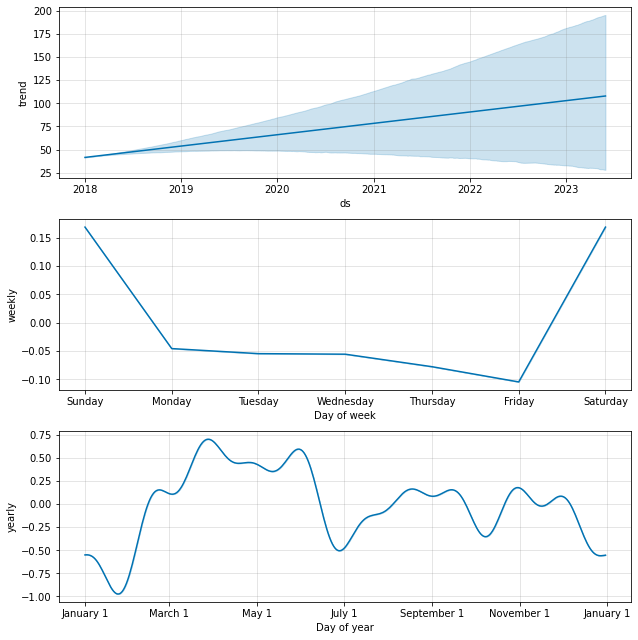

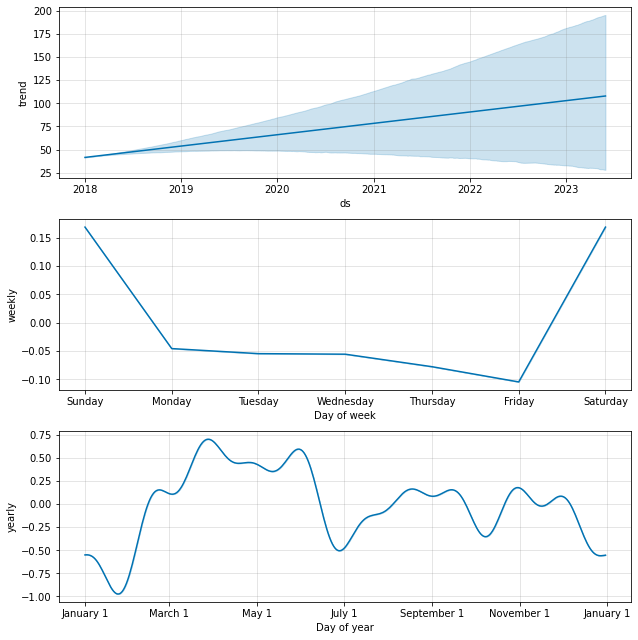

In [73]:
df_train = stock[stock.Date< "2018"]
df_valid = stock[stock.Date>= "2018"]

from prophet import Prophet
model= Prophet()
model.fit(df_train[['Date','Close']].rename(columns={"Date":"ds", "Close":"y"}))

forecast = model.predict(df_valid[['Date','Close']].rename(columns={"Date":"ds", "Close":"y"}))
model.plot_components(forecast)

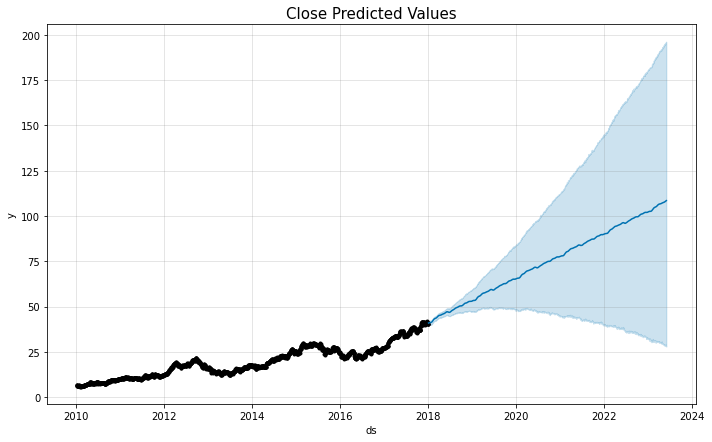

In [76]:
import matplotlib.pyplot as plt
model.plot(forecast)
plt.title('Close Predicted Values', fontsize=15)
plt.show()

# ARIMA

In [79]:
stock

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,week,day,year,day_of_week,Day_Name
0,2010-01-04,6.478688,6.511167,6.446815,6.496294,493729600,0.0,0.0,1,1,4,2010,0,Monday
1,2010-01-05,6.514205,6.544256,6.473225,6.507526,601904800,0.0,0.0,1,1,5,2010,1,Tuesday
2,2010-01-06,6.507524,6.533326,6.397335,6.404014,552160000,0.0,0.0,1,1,6,2010,2,Wednesday
3,2010-01-07,6.427690,6.435279,6.345731,6.392174,477131200,0.0,0.0,1,1,7,2010,3,Thursday
4,2010-01-08,6.383676,6.435280,6.346036,6.434672,447610800,0.0,0.0,1,1,8,2010,4,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3369,2023-05-23,173.130005,173.380005,171.279999,171.559998,50747300,0.0,0.0,5,21,23,2023,1,Tuesday
3370,2023-05-24,171.089996,172.419998,170.520004,171.839996,45143500,0.0,0.0,5,21,24,2023,2,Wednesday
3371,2023-05-25,172.410004,173.899994,171.690002,172.990005,56058300,0.0,0.0,5,21,25,2023,3,Thursday
3372,2023-05-26,173.320007,175.770004,173.110001,175.429993,54794100,0.0,0.0,5,21,26,2023,4,Friday


In [81]:
df= stock.copy()
df.set_index("Date", drop= False, inplace= True)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,week,day,year,day_of_week,Day_Name
Date,,,,,,,,,,,,,,
2010-01-04,2010-01-04,6.478688,6.511167,6.446815,6.496294,493729600,0.0,0.0,1,1,4,2010,0,Monday
2010-01-05,2010-01-05,6.514205,6.544256,6.473225,6.507526,601904800,0.0,0.0,1,1,5,2010,1,Tuesday
2010-01-06,2010-01-06,6.507524,6.533326,6.397335,6.404014,552160000,0.0,0.0,1,1,6,2010,2,Wednesday
2010-01-07,2010-01-07,6.427690,6.435279,6.345731,6.392174,477131200,0.0,0.0,1,1,7,2010,3,Thursday
2010-01-08,2010-01-08,6.383676,6.435280,6.346036,6.434672,447610800,0.0,0.0,1,1,8,2010,4,Friday


(0.0, 250.0)

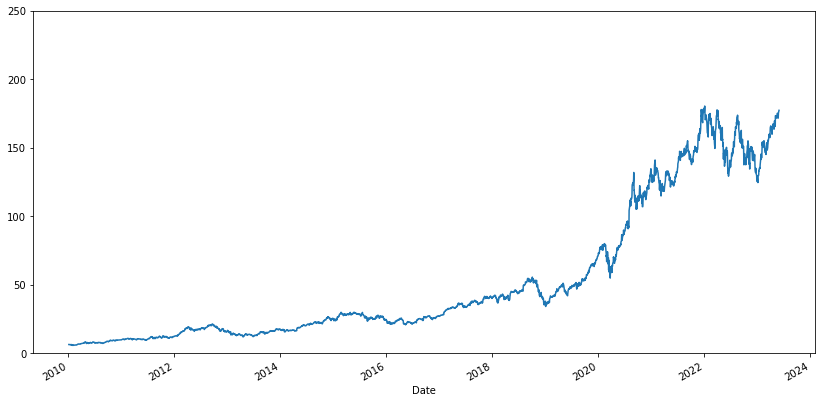

In [104]:
df.Close.plot(figsize=(14,7))
plt.ylim(0,250)
# plt.grid()

In [105]:
df.head(3)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,week,day,year,day_of_week,Day_Name
Date,,,,,,,,,,,,,,
2010-01-04,2010-01-04,6.478688,6.511167,6.446815,6.496294,493729600,0.0,0.0,1,1,4,2010,0,Monday
2010-01-05,2010-01-05,6.514205,6.544256,6.473225,6.507526,601904800,0.0,0.0,1,1,5,2010,1,Tuesday
2010-01-06,2010-01-06,6.507524,6.533326,6.397335,6.404014,552160000,0.0,0.0,1,1,6,2010,2,Wednesday


In [111]:
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low","Open","Close", "Volume"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)
df.head()

C:\Users\zeesh\AppData\Local\Temp/ipykernel_22924/2303211471.py:28: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(), inplace=True)
C:\Users\zeesh\AppData\Local\Temp/ipykernel_22924/2303211471.py:28: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.mean(), inplace=True)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,week,...,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,2010-01-04,6.478688,6.511167,6.446815,6.496294,493729600,0.0,0.0,1,1,...,51.792934,0.652043,0.966428,2.007030,250618080.0,250903808.0,252787120.0,54276444.0,69017016.0,88503272.0
2010-01-05,2010-01-05,6.514205,6.544256,6.473225,6.507526,601904800,0.0,0.0,1,1,...,6.496294,0.652043,0.966428,2.007030,493729600.0,493729600.0,493729600.0,54276444.0,69017016.0,88503272.0
2010-01-06,2010-01-06,6.507524,6.533326,6.397335,6.404014,552160000,0.0,0.0,1,1,...,6.501910,0.007943,0.007943,0.007943,547817216.0,547817216.0,547817216.0,76491416.0,76491416.0,76491416.0
2010-01-07,2010-01-07,6.427690,6.435279,6.345731,6.392174,477131200,0.0,0.0,1,1,...,6.469278,0.056799,0.056799,0.056799,549264768.0,549264768.0,549264768.0,54145684.0,54145684.0,54145684.0
2010-01-08,2010-01-08,6.383676,6.435280,6.346036,6.434672,447610800,0.0,0.0,1,1,...,6.450002,0.063458,0.060307,0.060307,543731968.0,531231392.0,531231392.0,62812308.0,57055388.0,57055388.0


### https://www.kaggle.com/code/rohanrao/a-modern-time-series-tutorial

# Auto ARIMAX
ARIMA (Auto Regressive Integrated Moving Average) models explain a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

ARIMA models require certain input parameters: p for the AR(p) part, q for the MA(q) part and d for the I(d) part. Thankfully, there is an automatic process by which these parameters can be chosen which is called Auto ARIMA.

When exogenous regressors are used with ARIMA it is commonly called ARIMAX.

Read more about ARIMA: https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

In [ ]:
df_train = df[df.Date < "2018"]
df_valid = df[df.Date >= "2018"]

In [180]:
exogenous_features = ['month', 'week', 'day', 'day_of_week','year',
       'High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30',
       'High_std_lag3', 'High_std_lag7', 'High_std_lag30', 'Low_mean_lag3',
       'Low_mean_lag7', 'Low_mean_lag30', 'Low_std_lag3', 'Low_std_lag7',
       'Low_std_lag30', 'Open_mean_lag3', 'Open_mean_lag7', 'Open_mean_lag30',
       'Open_std_lag3', 'Open_std_lag7', 'Open_std_lag30', 'Close_mean_lag3',
       'Close_mean_lag7', 'Close_mean_lag30', 'Close_std_lag3',
       'Close_std_lag7', 'Close_std_lag30', 'Volume_mean_lag3',
       'Volume_mean_lag7', 'Volume_mean_lag30', 'Volume_std_lag3',
       'Volume_std_lag7', 'Volume_std_lag30']

In [181]:
model = auto_arima(df_train.Close, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Close, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
# df_valid["Forecast_ARIMAX"] = forecast
# df_valid.loc[:, "Forecast_ARIMAX"] = forecast
df_valid.loc[:, "Forecast_ARIMAX"] = forecast.values

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1007.899, Time=2.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1013.062, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1013.790, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1013.722, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1016.863, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1015.918, Time=0.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1015.779, Time=0.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1013.645, Time=2.69 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1013.639, Time=2.89 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1015.400, Time=0.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1016.165, Time=0.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1016.323, Time=0.65 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1015.225, Time=1.65 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1010.876, Time=1.64 sec

Best model:  ARIMA(2,1,2)(0,0,0)

c:\Users\zeesh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\zeesh\AppData\Local\Temp/ipykernel_22924/1601174773.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.loc[:, "Forecast_ARIMAX"] = forecast.values


<AxesSubplot:xlabel='Date'>

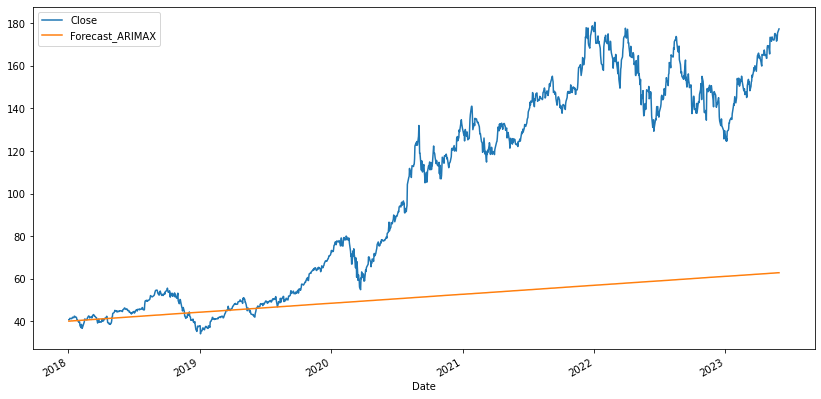

In [182]:
df_valid[["Close", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

# Facebook Prophet

In [185]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Date", "Close"] + exogenous_features].rename(columns={"Date": "ds", "Close": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "Close"] + exogenous_features].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

00:21:22 - cmdstanpy - INFO - Chain [1] start processing
00:21:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\zeesh\AppData\Local\Temp/ipykernel_22924/101899699.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_Prophet"] = forecast.yhat.values


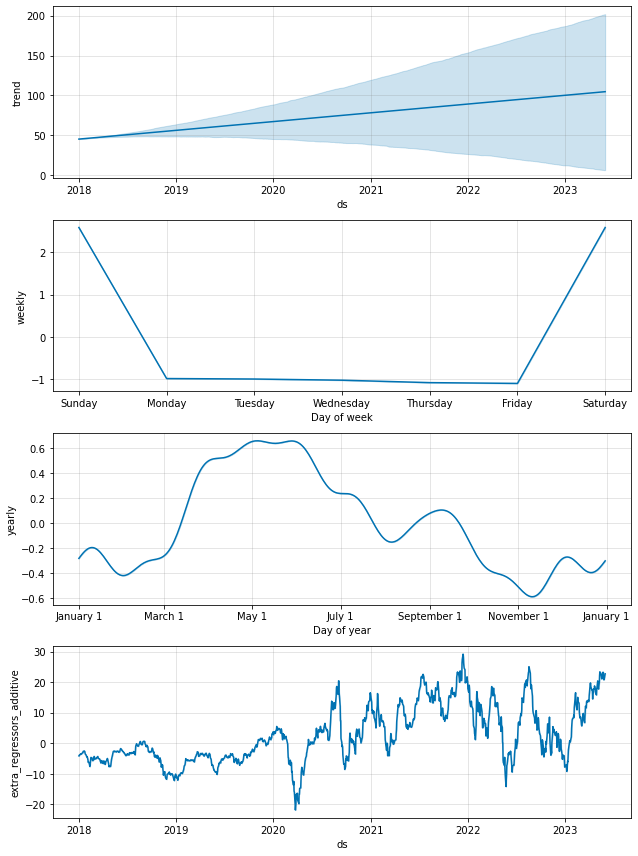

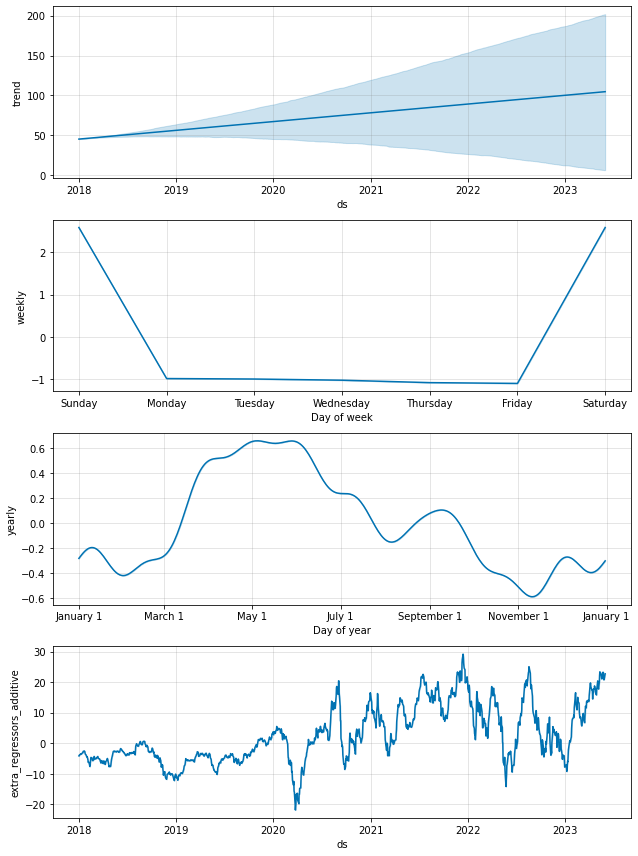

In [186]:
model_fbp.plot_components(forecast)

<AxesSubplot:xlabel='Date'>

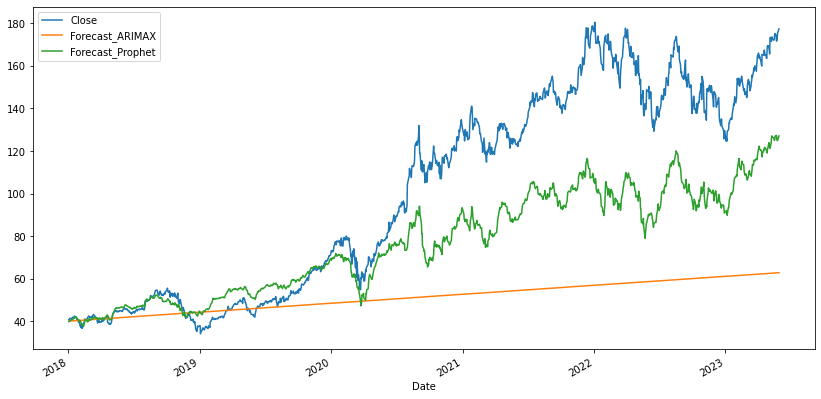

In [188]:
df_valid[["Close", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [190]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.Close, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.Close, df_valid.Forecast_Prophet)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.Close, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.Close, df_valid.Forecast_Prophet))

RMSE of Auto ARIMAX: 64.50045321089743
RMSE of Prophet: 34.65187770090693

MAE of Auto ARIMAX: 50.0868370292464
MAE of Prophet: 26.734544721593736


# LightGBM

In [196]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.Close.values)
dvalid = lgb.Dataset(df_valid[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_valid[exogenous_features])
df_valid["Forecast_LightGBM"] = forecast

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7763
[LightGBM] [Info] Number of data points in the train set: 2013, number of used features: 35
[LightGBM] [Info] Start training from score 19.800289


C:\Users\zeesh\AppData\Local\Temp/ipykernel_22924/3637758380.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_LightGBM"] = forecast


<AxesSubplot:xlabel='Date'>

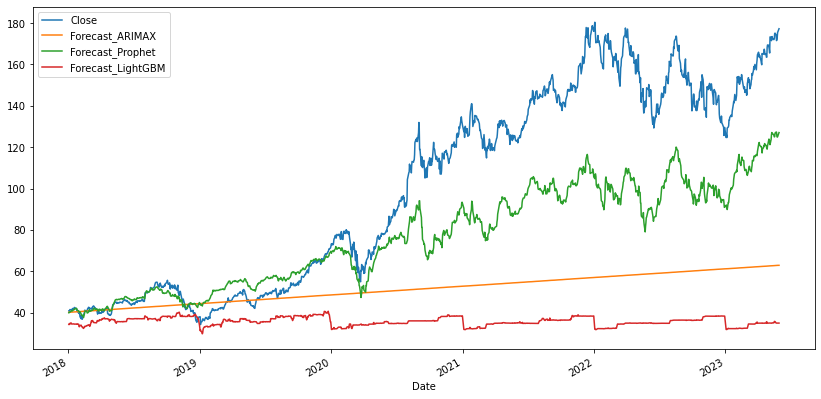

In [198]:
df_valid[["Close", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))